In [21]:
import plotly.graph_objects as go
import numpy as np 
import matplotlib.pyplot as plt 


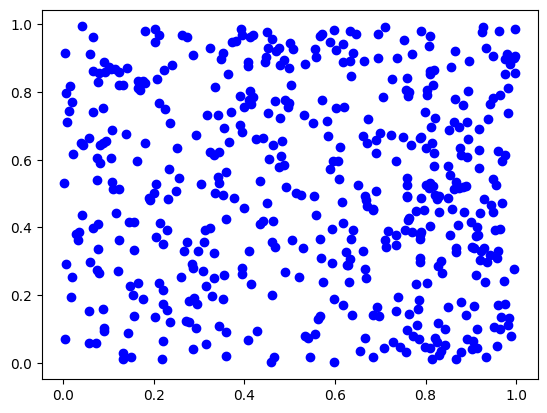

In [22]:
test_n=500
x1,y1 = np.random.rand(test_n), np.random.rand(test_n)
plt.plot(x1,y1,'ob')
# fig=go.Figure(data=go.Scatter(x=x1, y=y1, mode='markers'))
# fig.show()

(500,)
(500, 2)


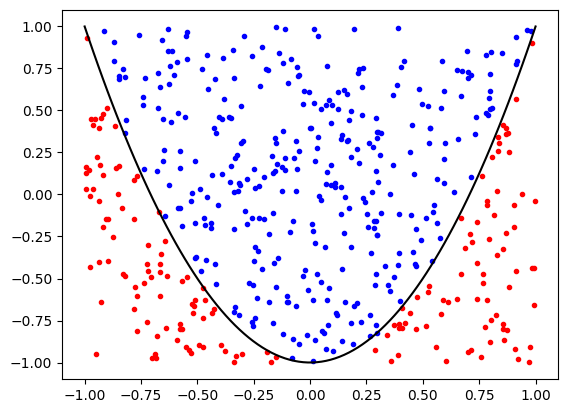

In [23]:
nsamples = 500
x, y = np.random.rand(nsamples)*2-1, np.random.rand(nsamples)*2-1
yb = (x**2)*2-1
label = (y>yb).astype(int)
print(label.shape)
coordinates = np.stack([x, y], axis=1)

print(coordinates.shape)
plt.plot(x[label==1], y[label==1], '.b')
plt.plot(x[label==0], y[label==0], '.r')

xgrid = np.linspace(-1, 1, 100)
ygrid = 2*(xgrid**2) -1 
plt.plot(xgrid, ygrid, '-k')

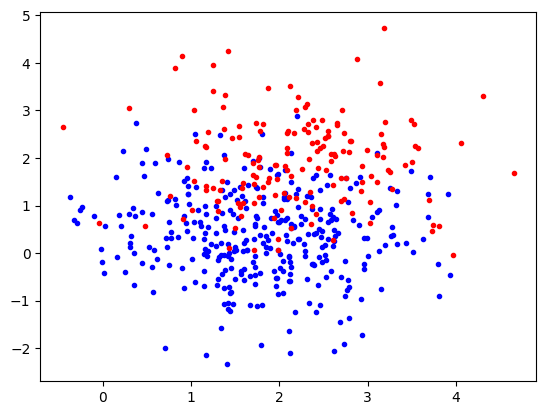

In [24]:
## generate features 
ndim = 3
np.random.seed(0)
feat_pos, feat_neg = np.random.randn(ndim), np.random.randn(ndim)
features = np.zeros((nsamples, ndim))
features[label==1] = feat_pos + np.random.randn((label==1).sum(), ndim)*0.9
features[label==0] = feat_neg + np.random.randn((label==0).sum(), ndim)*0.9

plt.plot(features[label==1,0], features[label==1,1], '.b')
plt.plot(features[label==0,0], features[label==0,1], '.r')

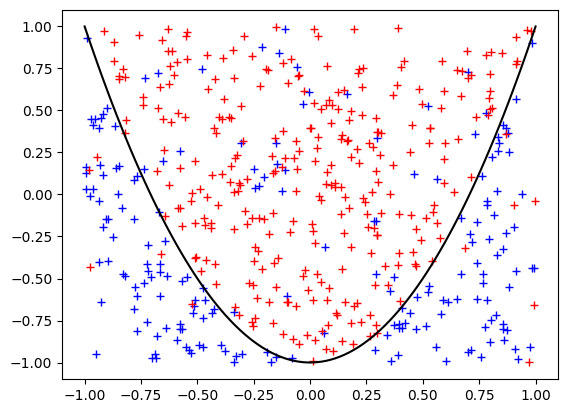

In [25]:
## clustering based on features; the clustering is based on k-means 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(features)
# plt.plot(features[kmeans.labels_==1,0], features[kmeans.labels_==1,1], 'ob')
# plt.plot(features[kmeans.labels_==0,0], features[kmeans.labels_==0,1], '+r')


## predict the labels of the data points
pred_features = kmeans.labels_
plt.plot(x[pred_features==1], y[pred_features==1], '+b')
plt.plot(x[pred_features==0], y[pred_features==0], '+r')
plt.plot(xgrid, ygrid, '-k')

(100, 100) (100, 100)


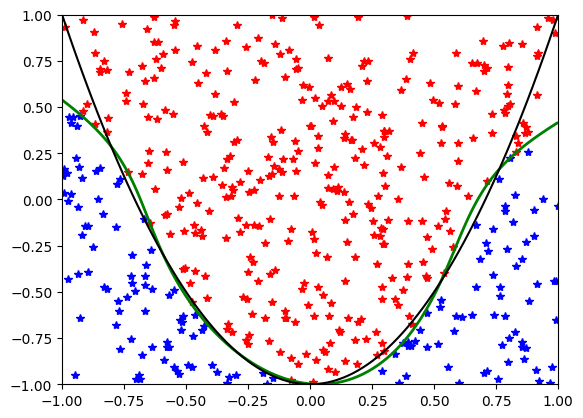

In [26]:
# train a SVM classifier with RBF kernel 
from sklearn.svm import SVC
clf = SVC(kernel='rbf', gamma=1, C=1)
clf.fit(coordinates, kmeans.labels_)

## predict the labels of the data points
svm_pred = clf.predict(coordinates)
plt.plot(coordinates[svm_pred==1,0], coordinates[svm_pred==1,1], '*b')
plt.plot(coordinates[svm_pred==0,0], coordinates[svm_pred==0,1], '*r')
## plot the decision boundary of clf 
xg = np.linspace(-1, 1, 100)
yg = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(xg, yg)
print(X.shape, Y.shape)
xy = np.vstack([X.ravel(), Y.ravel()]).T
Z = clf.decision_function(xy).reshape(X.shape)
plt.contour(X, Y, Z, levels=[0], linewidths=2, colors='g')

## plot the decision boundary
plt.plot(xgrid, ygrid, '-k')


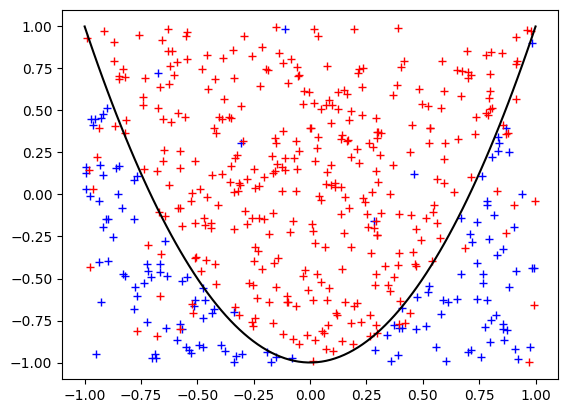

In [27]:
## classified based on features; the classifer is based on a SVM
from sklearn.svm import SVC
clf = SVC(kernel='linear', C=1)
clf.fit(features, svm_pred)

## predict the labels of the data points
pred_features = clf.predict(features)
plt.plot(x[pred_features==1], y[pred_features==1], '+b')
plt.plot(x[pred_features==0], y[pred_features==0], '+r')

plt.plot(xgrid, ygrid, '-k')


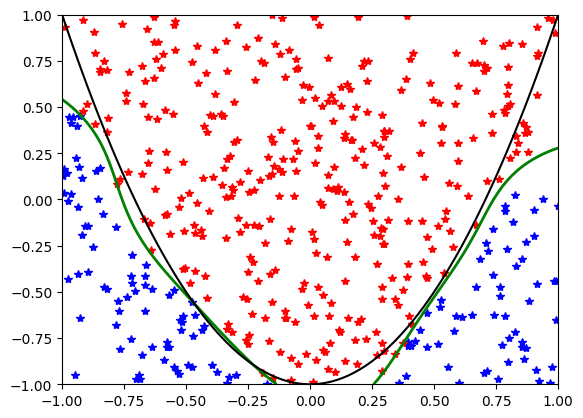

In [28]:
# train a SVM classifier with RBF kernel 
from sklearn.svm import SVC
clf = SVC(kernel='rbf', gamma=3,C=1)
clf.fit(coordinates, pred_features)

## predict the labels of the data points
pred = clf.predict(coordinates)
plt.plot(coordinates[pred==1,0], coordinates[pred==1,1], '*b')
plt.plot(coordinates[pred==0,0], coordinates[pred==0,1], '*r')
## plot the decision boundary of clf 
xg = np.linspace(-1, 1, 100)
yg = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(xg, yg)
xy = np.vstack([X.ravel(), Y.ravel()]).T
Z = clf.decision_function(xy).reshape(X.shape)
plt.contour(X, Y, Z, levels=[0], linewidths=2, colors='g')

## plot the decision boundary
plt.plot(xgrid, ygrid, '-k')


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network
class SimpleNeRF(nn.Module):
    def __init__(self):
        super(SimpleNeRF, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # Input layer (2 -> 64)
        self.fc2 = nn.Linear(64, 64) # Hidden layer (64 -> 64)
        self.fc3 = nn.Linear(64, 1)  # Output layer (64 -> 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.sign(x)  # Output the sign of the values

# Create the model
model = SimpleNeRF()

# Example input coordinates
input_coords = torch.tensor([[1.0, -2.0], [-3.0, 4.0]])

# Forward pass
output_signs = model(input_coords)
print(output_signs)

tensor([[ 1.],
        [-1.]], grad_fn=<SignBackward0>)


In [30]:
output_signs.shape

torch.Size([2, 1])

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network
class SimpleNeRF(nn.Module):
    def __init__(self):
        super(SimpleNeRF, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # Input layer (2 -> 64)
        self.fc2 = nn.Linear(64, 64) # Hidden layer (64 -> 64)
        self.fc3 = nn.Linear(64, 1)  # Output layer (64 -> 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return (torch.sigmoid(x))  # Output the sign of the values

# Generate synthetic data
torch.manual_seed(0)  # For reproducibility
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_coords = torch.from_numpy(coordinates).float().to(device) # 100 samples of (x, y) coordinates
labels = torch.from_numpy(pred_features).unsqueeze(1).float().to(device)  # Labels are the sign of the coordinates

# Create the model
model = SimpleNeRF().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(input_coords)
    loss = criterion(outputs, labels)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Test the model with some example inputs
print("Test outputs:", output_signs)

Epoch [100/1000], Loss: 0.1107
Epoch [200/1000], Loss: 0.0746
Epoch [300/1000], Loss: 0.0687
Epoch [400/1000], Loss: 0.0663
Epoch [500/1000], Loss: 0.0650
Epoch [600/1000], Loss: 0.0639
Epoch [700/1000], Loss: 0.0628
Epoch [800/1000], Loss: 0.0618
Epoch [900/1000], Loss: 0.0606
Epoch [1000/1000], Loss: 0.0592
Test outputs: tensor([[ 1.],
        [-1.]], grad_fn=<SignBackward0>)


In [32]:
pred_nerf = (outputs.detach().cpu().squeeze().numpy()>0.5)

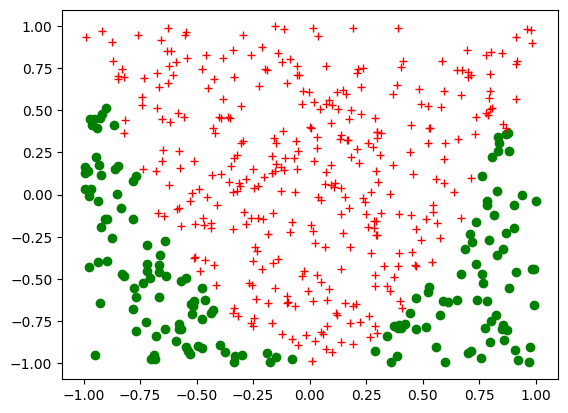

In [33]:
plt.plot(coordinates[pred_nerf,0], coordinates[pred_nerf,1], 'og')
plt.plot(coordinates[~pred_nerf,0], coordinates[~pred_nerf,1], '+r')

In [34]:
inputs = torch.from_numpy(np.stack([X.flatten(), Y.flatten()]).T).float().to(device)
labels = model(inputs).detach().cpu().numpy().reshape(X.shape)
labels.shape

(100, 100)

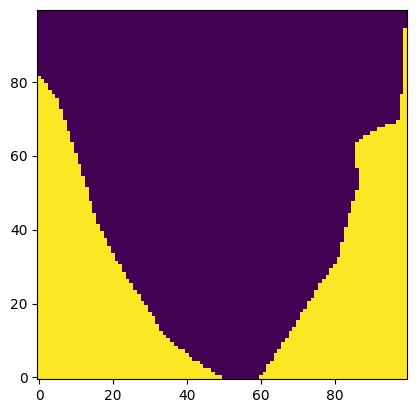

In [35]:
plt.imshow(labels>0.5)
# flip y axis
plt.gca().invert_yaxis()